In [1]:
# read the data queried in the last module

from astropy.table import Table
from gala.coordinates import GD1Koposov10

filename = 'gd1_data_05.hdf5'
selection_tbl = Table.read(filename, path="selection")
centerline_tbl = Table.read(filename, path="centerline")
selection_tbl.info



<Table length=1008>
   name    dtype    unit                              description                                class    
--------- ------- -------- ------------------------------------------------------------------ ------------
source_id   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn
       ra float64      deg                                                    Right ascension       Column
      dec float64      deg                                                        Declination       Column
     pmra float64 mas / yr                         Proper motion in right ascension direction       Column
    pmdec float64 mas / yr                             Proper motion in declination direction       Column
 parallax float64      mas                                                           Parallax       Column
     phi1 float64      deg                                                                          Column
     phi2 float64

Text(0, 0.5, 'Proper motion phi2 (GD1 frame)')

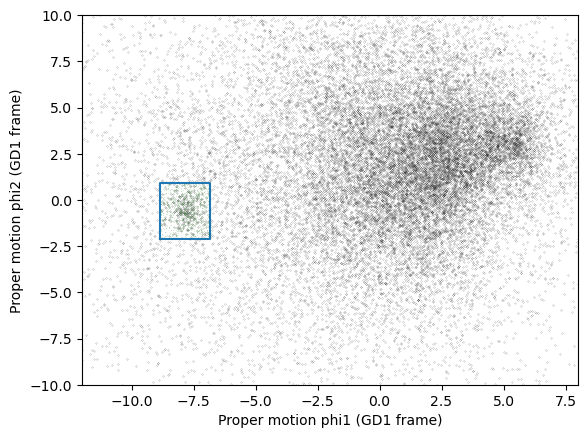

In [2]:
import matplotlib.pyplot as plt

pm1_range = (-8.85,-6.85)
pm2_range = (-2.1, 0.9) 

def make_rectangle(xrange, yrange):
    """Return the corners of a rectangle."""
    (x1,x2) = xrange
    (y1,y2) = yrange
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    return xs, ys

rect_pm1, rect_pm2 = make_rectangle(pm1_range, pm2_range)

def plot_proper_motion(df) :
    """Plot propermotion in GD1 coordinates from given dataframe"""
    x = df['pm_phi1']
    y = df['pm_phi2']
    plt.plot(x, y, 'ko', markersize=0.1, alpha=1)
        
    plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
    plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)');

    plt.xlim(-12, 8)
    plt.ylim(-10, 10);

    return plt

plot_proper_motion(centerline_tbl)

plt.plot(rect_pm1,rect_pm2)
x = selection_tbl['pm_phi1']
y = selection_tbl['pm_phi2']
plt.plot(x,y, "gx", markersize=0.1, alpha=0.3)

plt.xlabel("Proper motion phi1 (GD1 frame)")
plt.ylabel("Proper motion phi2 (GD1 frame)")


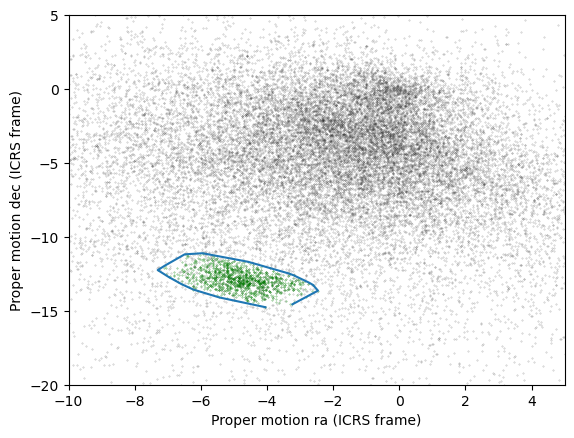

In [4]:
# repeat this plot in the ICRF frame
x=centerline_tbl['pmra']
y=centerline_tbl['pmdec']
plt.plot(x,y, "ko", markersize=.3, alpha=.3)

x=selection_tbl['pmra']
y=selection_tbl['pmdec']
plt.plot(x,y, 'gx', markersize=1, alpha=.3)

plt.xlabel("Proper motion ra (ICRS frame)")
plt.ylabel("Proper motion dec (ICRS frame)")
plt.xlim([-10, 5])
plt.ylim([-20, 5]);

# and create a convex hull of the points
points = selection_tbl[['pmra', 'pmdec']].to_pandas().to_numpy()

from scipy.spatial import ConvexHull

hull = ConvexHull(points)
pm_vertices=selection_tbl[hull.vertices]

pmra_poly = pm_vertices['pmra']
pmdec_poly = pm_vertices['pmdec']

plt.plot(pmra_poly, pmdec_poly)

In [7]:
import astropy.units as u
from gala.coordinates import GD1Koposov10
from astropy.coordinates import SkyCoord

# define the search area in GD1 coordinates
phi1_range = (-70, -20) * u.deg
phi2_range = (-5, 5) * u.deg
phi1_rect, phi2_rect = make_rectangle(phi1_range, phi2_range)

# transform to IRCS coordinates
corners = SkyCoord(phi1=phi1_rect, phi2=phi2_rect, frame=GD1Koposov10)
corners_icrs = corners.transform_to('icrs')

def skycoords_to_string(skycoords):
    t = skycoords.to_string()
    s = ' '.join(t)
    return s.replace(' ', ', ')


# now construct a query that uses that polygon as a search space
corners_icrs_str = skycoords_to_string(corners_icrs)
columns = 'source_id, ra, dec, pmra, pmdec'

query_base = """SELECT
    {columns}
    FROM gaiadr3.gaia_source
    WHERE parallax < 1
        AND bp_rp BETWEEN -0.75 AND 2
        AND 1 = CONTAINS(
            POINT(ra,dec),
            POLYGON({radec_vertices})
        )
        AND 1 = CONTAINS(
            POINT(pmra,pmdec),
            POLYGON( {pm_vertices} )
        )
"""

import numpy as np
import re

# format the string of vertices
# ra proper motion needs to be in the range 0-360
pmra = pm_vertices['pmra'].copy()
pmra += 360
# dec propper motion can be used as is
pmdec = pm_vertices['pmdec'].copy()

# zip the coordinates back up
vertices_arr=np.array(list(zip(pmra, pmdec)))

# and format as a string
vertices_str=np.array2string(vertices_arr, max_line_width=1000, separator=', ')
vertices_str = re.sub('[\\[\\]()]', '', vertices_str)

query = query_base.format(columns=columns, radec_vertices=corners_icrs_str, pm_vertices=vertices_str)


In [8]:
# run the job
from astroquery.gaia import Gaia

job = Gaia.launch_job_async(query)
cantidate_tbl = job.get_results()
len(cantidate_tbl)

INFO: Query finished. [astroquery.utils.tap.core]


8100

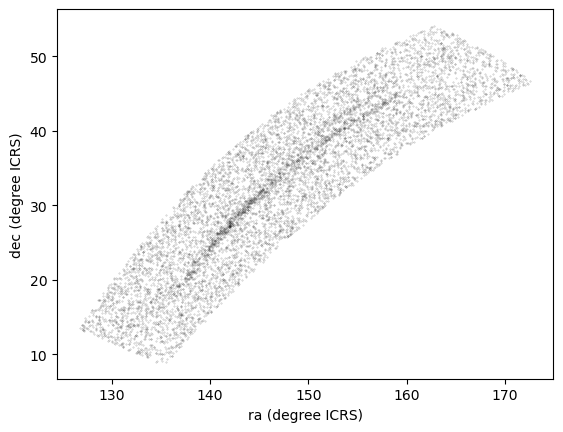

In [14]:
# plot again

x = cantidate_tbl['ra']
y = cantidate_tbl['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');


In [15]:
# transform these coordinates back to GD-1
from gala.coordinates import reflex_correct, GD1Koposov10
from astropy.coordinates import SkyCoord

def create_icrs_skycoord (table):
    return SkyCoord(
        ra=table['ra'], 
        dec=table['dec'],
        pm_ra_cosdec=table['pmra'],
        pm_dec=table['pmdec'], 
        distance=8*u.kpc, 
        radial_velocity=0*u.km/u.s
    )

def icrs_to_gd1 (coord) :
    transformed = coord.transform_to(GD1Koposov10)
    return reflex_correct(transformed)

icrs = create_icrs_skycoord(cantidate_tbl)
gd1 = icrs_to_gd1(icrs)

cantidate_tbl['phi1'] = gd1.phi1
cantidate_tbl['phi2'] = gd1.phi2
cantidate_tbl['pm_phi1'] = gd1.pm_phi1_cosphi2
cantidate_tbl['pm_phi2'] = gd1.pm_phi2



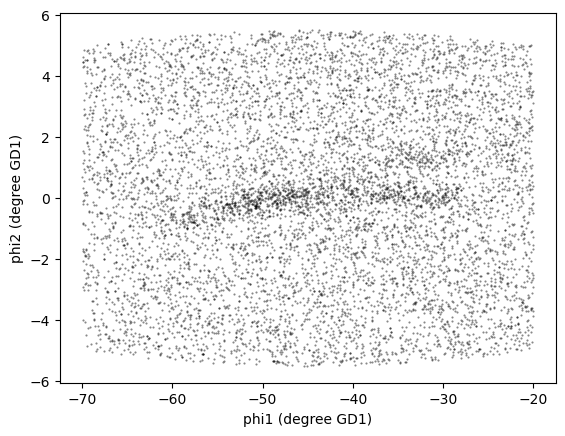

In [16]:
# and render the plot in GD1

x = cantidate_tbl['phi1']
y = cantidate_tbl['phi2']
plt.plot(x, y, 'ko', markersize=0.5, alpha=0.5)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)');


In [17]:
import pandas as pd

# create a dictionary for the selection vertices
d = dict(radec_vertices = corners_icrs, pm_vertices = pm_vertices)


filename = 'gd1_data_05.hdf5'
selection_tbl.write(filename, path="selection", serialize_meta=True, overwrite=True)
centerline_tbl.write(filename, path="centerline", serialize_meta=True, append=True)


# write tables for the selection vertices

radec_vertices = Table([corners_icrs.ra, corners_icrs.dec], names=('ra', 'dec'))
radec_vertices.write(filename, path="radec_vertices", serialize_meta=True, append=True)
pm_vertices_tbl = Table(vertices_arr, names=('pmra', 'pmdec') )
pm_vertices_tbl.write(filename, path="pm_vertices", serialize_meta=True, append=True)


from os.path import getsize
MB = 1024*1024
getsize(filename)/MB

2.0101823806762695

In [12]:
pm_vertices_tbl = Table(vertices_arr, names=('pmra', 'pmdec') )
pm_vertices_tbl

pmra,pmdec
float64,float64
356.7694262263789,-14.557541016156375
357.540490506547,-13.636221954067512
357.38827797276826,-13.247974712069263
357.2652859921471,-13.090544709622938
356.8007685380062,-12.594265302440828
356.6591745421245,-12.476119260818695
355.4257205642564,-11.684245303834384
354.04840727567864,-11.105478836426514
353.5087863944975,-11.180884065106781
